In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Pendulum data-efficiency
query = {"$and": [{"$or": [{"tags": "small-data-efficiency"}, {"tags": "data-efficiency"}]},
                  {"state": "finished"},
                  {"config.body_args": [2]},
                  {"config.body_class": "ChainPendulum"},
                  {"config.network_class": {"$ne": "LNN"}},
                  {"config.network_class": {"$ne": "DeLaN"}}
                 ]}

runs, histories = zip(*get_history(query=query))

wandb: Network error resolved after 0:00:14.882811, resuming normal operation.
wandb: Network error resolved after 0:00:10.280922, resuming normal operation.


In [4]:
#trainers = []
#for run in runs:
#    trainer, pl_model = load_model_from_run(run)
#    trainer.model = pl_model
    
#    trainers.append(trainer)
    
#for trainer in trainers:
#    trainer.test()

In [5]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    n_train = run.config["n_train"]
    #n_train = (r"$N_{train}$=", f"{n_train}")
    n_train = n_train

    rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.cpu().numpy()
    avg_rel_err_pert = rel_err_pert_true.cpu().numpy()

    series += avg_rel_err_pred.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pred", i) for i in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pert", i) for i in range(len(avg_rel_err_pert))]
    #series.append(avg_rel_err_pert)#
    #labels.append((body, network_class, "avg_rel_err_pert"))

File already exists
File already exists
File already exists
File already exists


In [6]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
index = pd.MultiIndex.from_tuples(labels, names =('n_train', 'Network', "Series", "Batch"))
df = pd.DataFrame(series, index=index).T

In [7]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt

In [8]:
time = pd.Series(np.arange(0, integration_time, dt))
df.index = time

In [9]:
df.head()

n_train              100                                                  \
Network             CHNN                                                   
Series  avg_rel_err_pred                                                   
Batch                 0         1         2             3             4    
0.0         1.820283e-12  0.000000  0.000000  1.468485e-08  2.147322e-08   
0.1         8.219353e-05  0.000135  0.000138  4.536887e-05  7.784343e-05   
0.2         1.527737e-04  0.000252  0.000279  8.695973e-05  1.875569e-04   
0.3         2.049712e-04  0.000355  0.000421  1.109203e-04  3.461219e-04   
0.4         2.357842e-04  0.000449  0.000565  1.048794e-04  5.448819e-04   

n_train                                                                        \
Network                                                                         
Series                                                                          
Batch              5             6             7             8             9    
0.0      2.451650e-08  1.146200e-08  1.743435e-08  3.378843e-09  3.532519e-09   
0.1      1.323566e-04  6.467909e-04  3.126443e-04  3.901438e-04  3.343597e-04   
0.2      2.696962e-04  1.383340e-03  6.181883e-04  8.011548e-04  6.809602e-04   
0.3      4.052832e-04  2.200292e-03  9.821422e-04  1.225983e-03  1.022443e-03   
0.4      5.313882e-04  3.094204e-03  1.481964e-03  1.656262e-03  1.340427e-03   

n_train  ...                                                           \
Network  ...               NN                                           
Series   ... avg_rel_err_pert                                           
Batch    ...               90        91        92        93        94   
0.0      ...         0.000129  0.000055  0.000049  0.000034  0.000071   
0.1      ...         0.000130  0.000057  0.000051  0.000035  0.000071   
0.2      ...         0.000132  0.000060  0.000053  0.000040  0.000067   
0.3      ...         0.000136  0.000063  0.000055  0.000047  0.000067   
0.4      ...         0.000142  0.000065  0.000057  0.000054  0.000068   

n_train                                                    
Network                                                    
Series                                                     
Batch          95        96        97        98        99  
0.0      0.000056  0.000077  0.000052  0.000048  0.000098  
0.1      0.000057  0.000074  0.000050  0.000049  0.000089  
0.2      0.000061  0.000074  0.000050  0.000050  0.000080  
0.3      0.000072  0.000076  0.000051  0.000050  0.000071  
0.4      0.000089  0.000078  0.000056  0.000051  0.000063  

[5 rows x 7200 columns]

In [10]:
df = df.sort_index(axis=1, level="n_train", ascending=True)

In [11]:
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000

In [12]:
df_batch_avg = df.T.groupby(level=("n_train", "Network", "Series")).mean().T

n_systems = len(df.columns.unique("n_train"))
n_networks = len(df.columns.unique("Network"))

# TODO: uncomment when more than 1 system
fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
#fig, axes = plt.subplots(ncols=2, figsize=(4 * 2, 4))

for system, ax in zip(df.columns.unique("n_train"), axes.flatten()):
    df_batch_avg.loc[:, (system, slice(None), "avg_rel_err_pred")].plot(ax=ax, linewidth=2.5)
    ax.set(yscale="log",
           title=system,
           xlabel=f"Forward prediction (seconds)",
           ylim=(1e-5, 2))
    
    # Just take the perturbation curve from NN
    df_batch_avg.loc[:, (system, "NN", "avg_rel_err_pert")].plot(ax=ax,  linewidth=2.5)
    
    ax.axvline(chunk_len, label="Training trajectory length", color="k", linestyle="--", linewidth=1.0)
    #ax.legend([])
    
    # TODO: remember to order this correctly if new plots are added
    ax.legend(list(df_batch_avg[system].columns.unique("Network")) + [r"$z_0 + \varepsilon$", r"$T_{minibatch}$"],
              loc="lower right",
              framealpha=0.4)
axes[0].set(ylabel=r"Rel. Error: $||z - z_{true}||_2 / ||z + z_{true}||_2$")
fig.tight_layout()

In [13]:
df_avg_int_err = df.apply(lambda y: np.exp(np.trapz(np.log(y + 1e-8), dx=dt) / integration_time))
df_avg_int_err = df_avg_int_err.T.groupby(level=("n_train", "Network", "Series")).mean().T
df_avg_int_err.head()

n_train  Network  Series          
20       CHNN     avg_rel_err_pert    0.000275
                  avg_rel_err_pred    0.008446
         CLNN     avg_rel_err_pert    0.000219
                  avg_rel_err_pred    0.020472
         HNN      avg_rel_err_pert    0.000201
dtype: float64

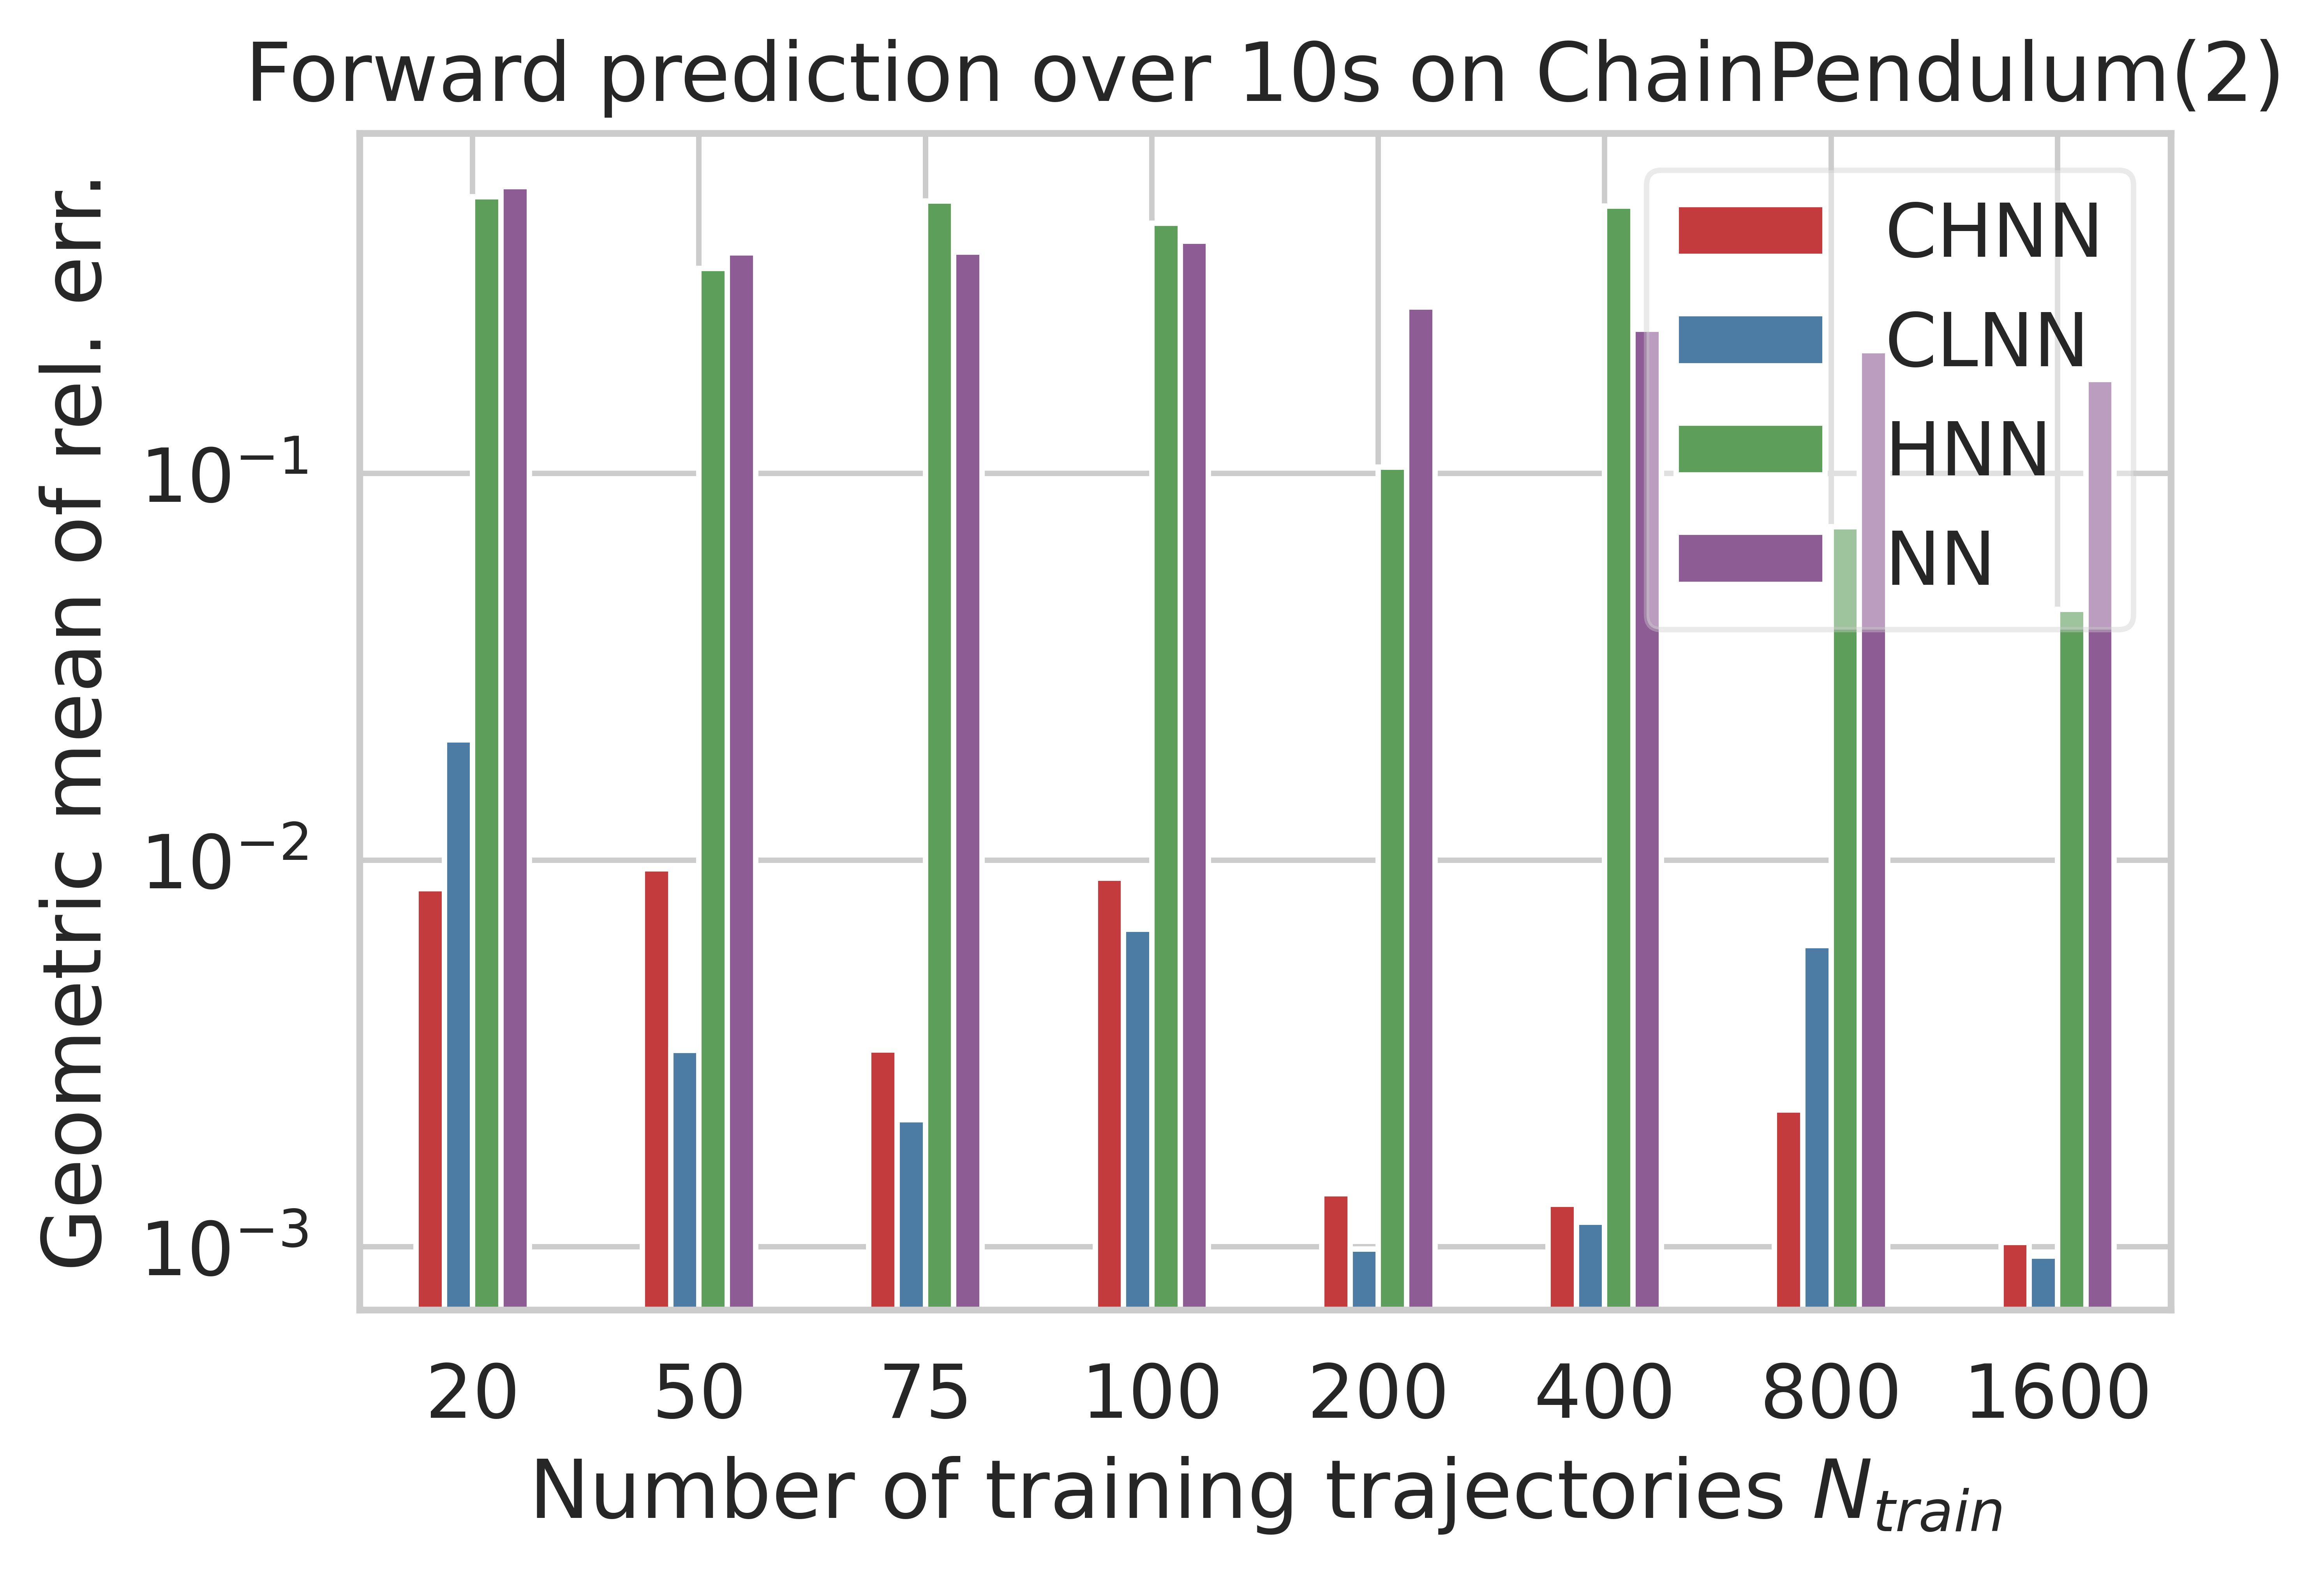

In [18]:
# TODO: uncomment when more than 1 system
#fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
fig, ax = plt.subplots()

body_args = tuple(run.config["body_args"])
if len(body_args) == 0:
    body_args = ""
elif len(body_args) == 1:
    body_args = f"({body_args[0]})"
else:
    body_args = f"{body_args}"
body = f"{run.config['body_class']}{body_args}"

df_avg_int_err.loc[(slice(None), slice(None), "avg_rel_err_pred")].unstack().plot(kind='bar', ax=ax)
ax.set(title=f"Forward prediction over {integration_time}s on {body}",
       xlabel="Number of training trajectories "+r"$N_{train}$",
       yscale="log",
       ylabel="Geometric mean of rel. err.")
ax.set_xticklabels(list(df_batch_avg.columns.unique("n_train")), rotation=0)
ax.legend(title=None, loc="upper right", framealpha=0.4)

In [19]:
fig.savefig("data-efficiency.pdf", bbox_inches="tight")